# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных

import plotly
import plotly.express as px

%matplotlib inline

Итак, прочитаем нашу таблицу:

In [129]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки:**
* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которыми воспользовался клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

### Соотношение ушедших и лояльных клиентов

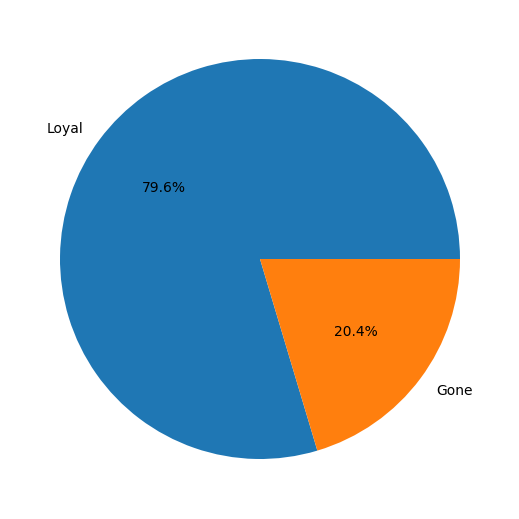

In [130]:
df_churn_data = churn_data.copy()
df_churn_data['ExitedName'] = df_churn_data['Exited'].apply(lambda x: 'Loyal' if x == 0 else 'Gone')

client_combinations = df_churn_data['ExitedName'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    client_combinations,
    labels=client_combinations.index,
    autopct='%.1f%%'    
);

### График, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов.

In [131]:
balance = df_churn_data[df_churn_data['Balance'] > 2500]

fig = px.histogram(
    balance,
    x='Balance',    
    labels={'Balance':'Баланс на счету клиента, $', 'y':'Количество клиентов, чел.'},
    marginal='box',
    nbins=30,
);
fig.show()



### Баланс клиента в разрезе признака оттока.

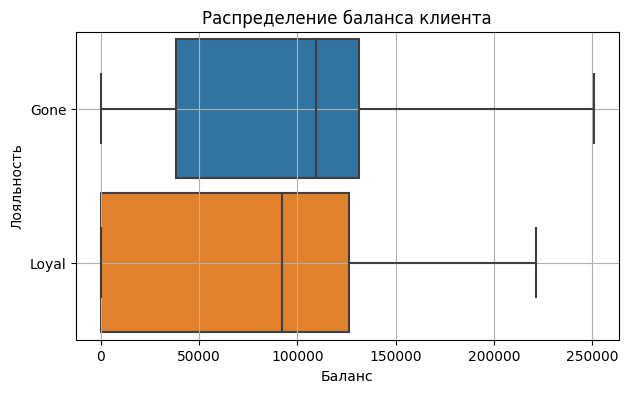

In [132]:
fig = plt.figure(figsize=(7, 4))
boxplot = sns.boxplot(
    data=df_churn_data,
    y='ExitedName',
    x='Balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиента');
boxplot.set_xlabel('Баланс');
boxplot.set_ylabel('Лояльность');
boxplot.grid()

### Распределение возраста в разрезе признака оттока.

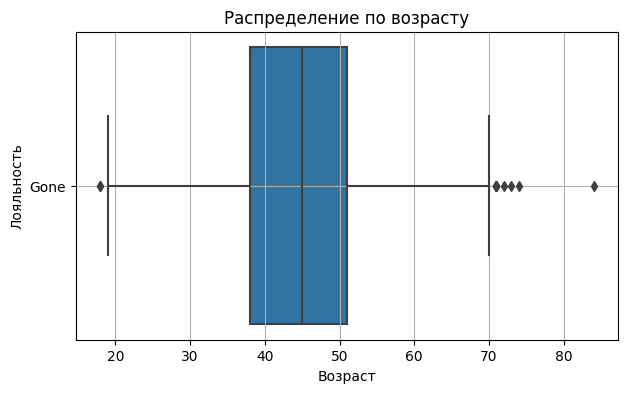

In [133]:
balance_age = df_churn_data[df_churn_data['Exited'] == 1]

fig = plt.figure(figsize=(7, 4))
boxplot = sns.boxplot(
    data=balance_age,
    x='Age',
    y='ExitedName',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение по возрасту');
boxplot.set_xlabel('Возраст');
boxplot.set_ylabel('Лояльность');
boxplot.grid()

### График, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты.

In [134]:
fig = px.scatter(
    data_frame=df_churn_data, #датафрейм
    y='CreditScore', #ось абсцисс
    x='EstimatedSalary', #ось ординат
    color='ExitedName',
    height=500, #высота
    width=1000, #ширина
    title='Кредитный рейтинг от зарплаты' #заголовок
)
fig.show()

### Кто чаще уходит, мужчины или женщины.

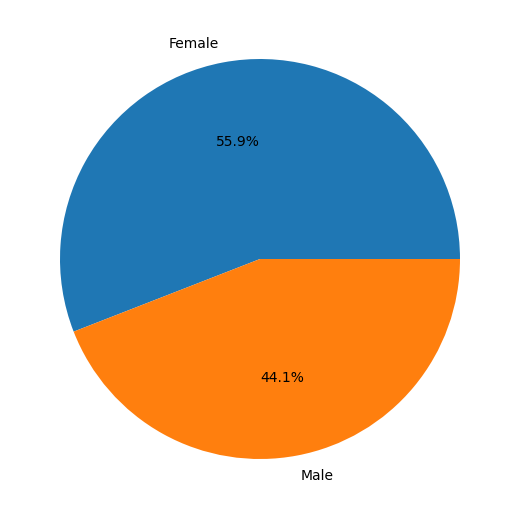

In [135]:
gone = df_churn_data[df_churn_data['ExitedName'] == 'Gone']

client_gender = gone['Gender'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    client_gender,
    labels=client_gender.index,
    autopct='%.1f%%'    
);

### Отток клиентов от числа приобретённых у банка услуг.

In [136]:
exited_count = df_churn_data.groupby(['NumOfProducts'])['ExitedName'].value_counts().unstack(fill_value=0)

fig = px.bar(
    data_frame=exited_count,
    x=exited_count.index,
    y=['Gone', 'Loyal'],
    height=500, #высота
    width=700, #ширина
    title='Взаимосвязь оттока клиентов и числа приобретённых услуг'
)
fig.show()

### Влияние наличие статуса активного клиента на отток клиентов.

In [137]:
isactive_count = df_churn_data.groupby(['Exited'])['IsActiveMember'].value_counts().unstack(fill_value=0)

fig = px.bar(
    data_frame=isactive_count,
    x=isactive_count.index,
    y=['Loyal', 'Gone'],
    height=500, #высота
    width=700, #ширина
    title='Взаимосвязь оттока клиентов и статуса активности'
)
fig.show()

### В какой стране доля ушедших клиентов больше.

In [138]:
choropleth_data = df_churn_data.groupby(['Geography'])['ExitedName'].value_counts().unstack(fill_value=0)
choropleth_data['ExitedSum'] = choropleth_data['Gone'] + choropleth_data['Loyal']
choropleth_data['ExitedPercent'] = (choropleth_data['Gone'] / choropleth_data['ExitedSum']*100).round(1)

display(choropleth_data)
fig = px.choropleth(
    data_frame=choropleth_data, #датафрейм
    locations=choropleth_data.index, #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой plotly
    color="ExitedPercent", #от чего зависит цвет       
    range_color=[15, 35],
    title='Ушедшие клиенты по странам', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)
# название стран и информация на карте
fig.add_scattergeo(
    locations = choropleth_data.index,
    locationmode = "country names",
    # данные для подписей на карте
    customdata = np.stack((choropleth_data.Gone, choropleth_data.ExitedPercent), axis=-1), 
    text = choropleth_data.index,
    # шаблон текста
    texttemplate='<b style="color: #3C4048; font-size:12px;">%{text}</b>'
                 '<br>%{customdata[0]}'
                 '<br>%{customdata[1]}%',
    hoverinfo = 'skip', # отмена всплывающего окна
    mode = 'text'
)

#отображаем его
fig.show()

ExitedName,Gone,Loyal,ExitedSum,ExitedPercent
Geography,,,,
France,810,4204,5014,16.2
Germany,814,1695,2509,32.4
Spain,413,2064,2477,16.7


В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [139]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [140]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [141]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [142]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

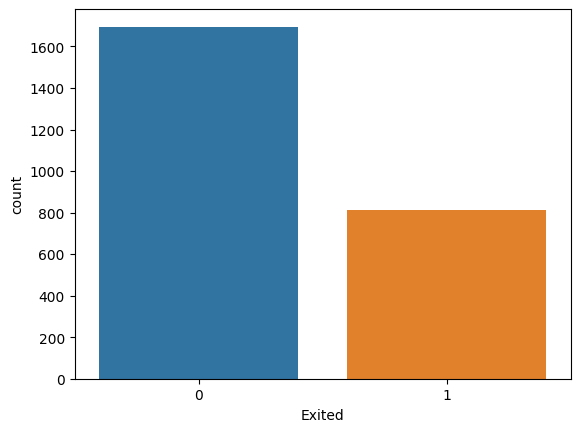

In [143]:
churn_data.describe(include='object')
sns.countplot(data=churn_data, x='Exited');

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [144]:
churn_data['BalanceSalaryRatio']=churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge']=churn_data['Tenure']/churn_data['Age']
churn_data['CreditScoreGivenAge']=churn_data['CreditScore']/churn_data['Age']

In [145]:
#Исследуем категориальные признаки
types = churn_data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['Gender']

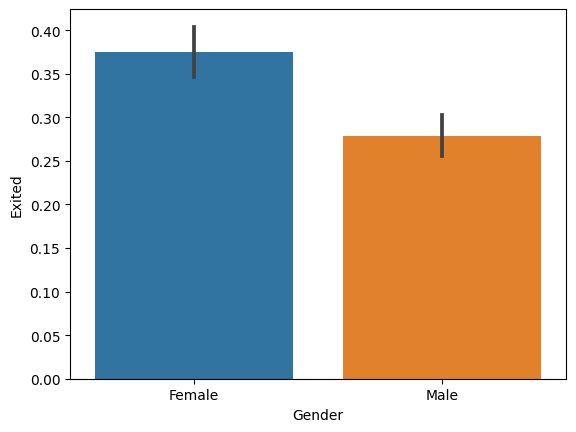

In [146]:
#Строим столбчатую диаграмму доли (среднее по столбцу Exited) в зависимости от пола
mean_barplot = sns.barplot(data=churn_data, x='Gender', y='Exited')


In [147]:
#Кодируем текстовые категориальные признаки
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

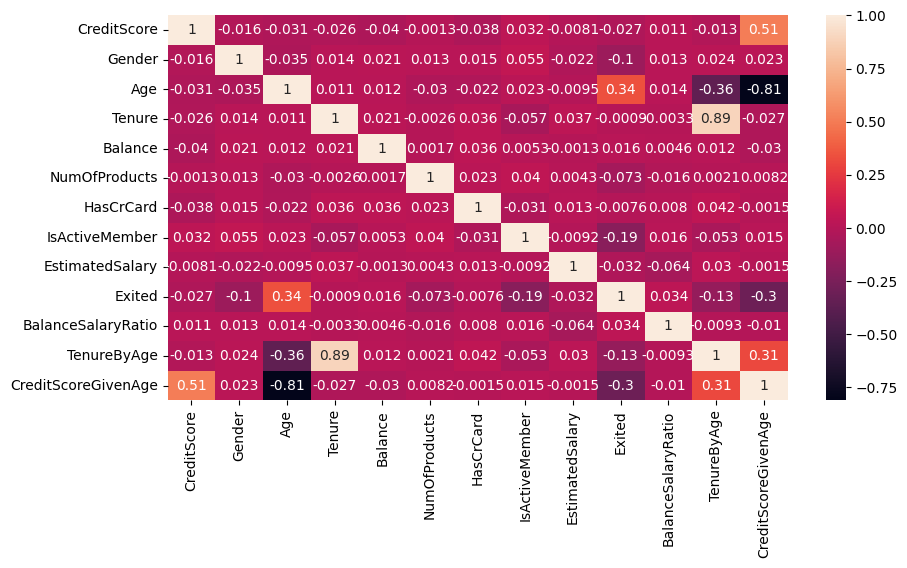

In [148]:
#Оцениваем мультиколинеарность и взаимосвязь с целевым признаком
plt.figure(figsize = (10, 5))
sns.heatmap(churn_data.corr(), annot = True);

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [149]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [150]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [151]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [152]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [153]:
#Производим нормализацию данных с помощью standart нормализации
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

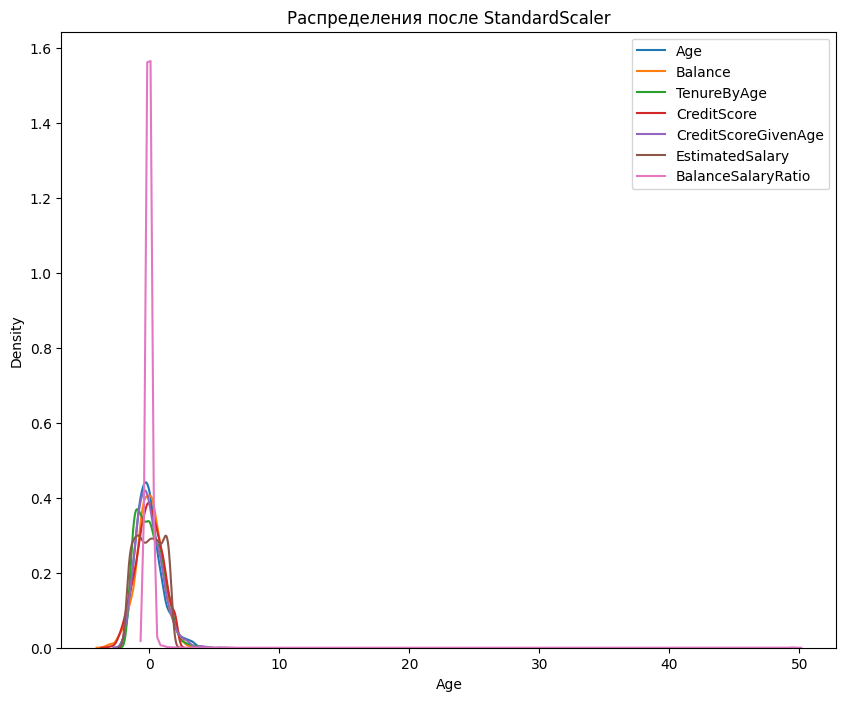

In [154]:
columns_not_cat = ['Age', 'Balance', 'TenureByAge', 'CreditScore', 'CreditScoreGivenAge', 'EstimatedSalary', 'BalanceSalaryRatio']

# Инициализируем нормализатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# Признаки подлежащие нормализации

df_scaler = s_scaler.fit_transform(churn_data[columns_not_cat].values)

df_scaler = pd.DataFrame(df_scaler, columns=columns_not_cat)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

for column in columns_not_cat:
    sns.kdeplot(df_scaler[column], ax=ax1, label=column)
    plt.legend()

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> мы хотим найти как можно больше клиентов, которые потенциально могут уйти от нас. Чтобы повысить их лояльность, мы планируем использовать ресурсы колл-центра. Однако они ограничены и мы не можем звонить всем клиентам. Определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдёт с большей вероятностью. 

В таком случае нам подойдёт следующая метрика.

F-мера — это взвешенное среднее гармоническое между precision и recall:

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Преимущество F-меры в том, что она своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет близка к 0, то и F1 будет близка к 0. 

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [155]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации    
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [156]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.43      0.51       610

    accuracy                           0.73      1881
   macro avg       0.70      0.65      0.66      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       424
           1       0.60      0.42      0.49       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.70      0.72      0.70       628



Вывод: Модель не дообучена.

In [157]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    penalty='l1',
    C=100,
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=100, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [158]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.44      0.52       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.67      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       424
           1       0.60      0.42      0.49       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.70      0.72      0.70       628



При L1-регуляризации мы добавляем в функцию потерь штраф из суммы модулей параметров, а саму функцию logloss умножаем на коэффициент C. Чем больше C, тем меньше «сила» регуляризации.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [159]:
#Производим нормализацию данных с помощью PolynomialFeatures нормализации
polynomial = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
polynomial.fit(X_train_scaled)
X_train_polynomial = polynomial.transform(X_train_scaled)
X_test_polynomial = polynomial.transform(X_test_scaled)

In [160]:
#Создаем объект класса логистическая регрессия
log_reg_p = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации    
    random_state=42, #генератор случайных чисел
    max_iter=10000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_p.fit(X_train_polynomial, y_train)

LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [161]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_p.predict(X_train_polynomial)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_p.predict(X_test_polynomial)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1271
           1       0.61      0.62      0.61       610

    accuracy                           0.75      1881
   macro avg       0.71      0.71      0.71      1881
weighted avg       0.75      0.75      0.75      1881

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       424
           1       0.57      0.65      0.61       204

    accuracy                           0.73       628
   macro avg       0.70      0.71      0.70       628
weighted avg       0.74      0.73      0.73       628



Вывод: Сравнивая результат с полученным ранее, качество моделив улучшается.

In [162]:
#Создаем объект класса логистическая регрессия
log_reg_p = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    penalty='l1',
    C=100,    
    random_state=42, #генератор случайных чисел
    max_iter=10000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_p.fit(X_train_polynomial, y_train)

LogisticRegression(C=100, max_iter=10000, penalty='l1', random_state=42,
                   solver='saga')

In [163]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_p.predict(X_train_polynomial)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_p.predict(X_test_polynomial)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1271
           1       0.61      0.62      0.61       610

    accuracy                           0.75      1881
   macro avg       0.71      0.71      0.71      1881
weighted avg       0.75      0.75      0.75      1881

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       424
           1       0.57      0.65      0.61       204

    accuracy                           0.73       628
   macro avg       0.70      0.71      0.70       628
weighted avg       0.74      0.73      0.73       628



При L1-регуляризации мы добавляем в функцию потерь штраф из суммы модулей параметров, а саму функцию logloss умножаем на коэффициент C. Чем больше C, тем меньше «сила» регуляризации.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

c:\Users\Kovyljan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Kovyljan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



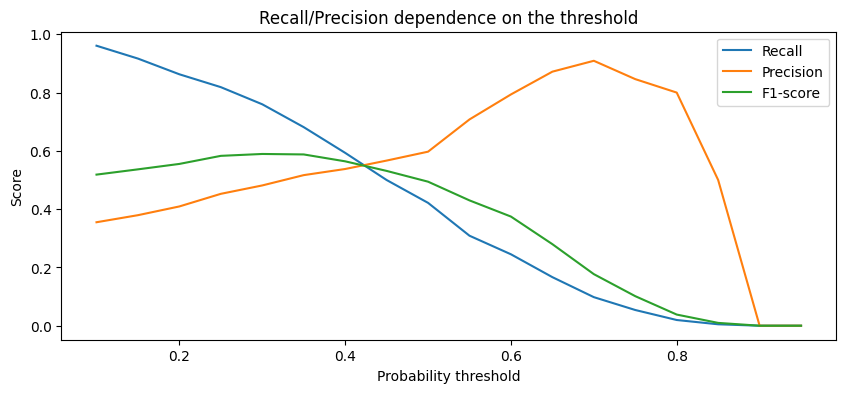

In [164]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [165]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.41
#Людей, у которых вероятность уйти больше 0.41 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))


#Нас интересует только вероятность класса (второй столбец)
y_train_proba_pred = log_reg.predict_proba(X_train_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_opt))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       424
           1       0.54      0.58      0.56       204

    accuracy                           0.71       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.71      0.71      0.71       628

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1271
           1       0.56      0.58      0.57       610

    accuracy                           0.71      1881
   macro avg       0.68      0.68      0.68      1881
weighted avg       0.72      0.71      0.72      1881



С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как ушедших тех клиентов, в которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем клиентов, которые уходят, но модель выдаёт низкую вероятность оттока, то есть мы уменьшаем охват (recall).

При этом значение F-меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка threshold=0.41, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства F-меры.

Однако максимум F-меры достигается в другой точке — threshold=0.3. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что для нас все таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при threshold=0.41.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [166]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [2]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь